# Testing regularization of likelihood functions

In [1]:
%pylab inline
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('../../utils/flowpm/')
import tfpmconfig, tfpm
import tfpmfuncs as tfpf

sys.path.append('../../utils/')
sys.path.append('../../')
import tools


In [3]:
from matplotlib.colors import LogNorm

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


In [5]:
from time import time

In [6]:
bs, nc = 100, 32
config = tfpmconfig.Config(bs=bs, nc=nc)
path = '../../data/toy/L0100_N0032/S{:04d}/'
seed = 0 
s = np.load(path.format(seed) + 's.npy')
d = np.load(path.format(seed) + 'd.npy')
p = np.load(path.format(seed) + 'p.npy')

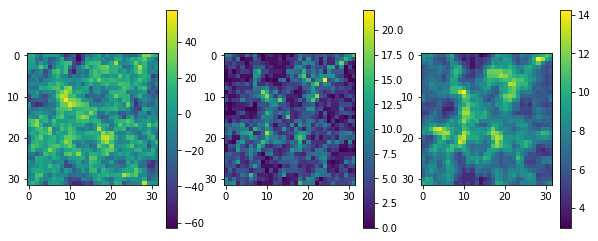

In [7]:
plt.figure(figsize = (10, 4))
ax = plt.subplot(1, 3, 1)
plt.imshow(s.sum(axis=0));colorbar()
ax = plt.subplot(1, 3, 2)
plt.imshow(p.sum(axis=0));colorbar()
ax = plt.subplot(1, 3, 3)
plt.imshow(log10(d+1).sum(axis=0));colorbar()

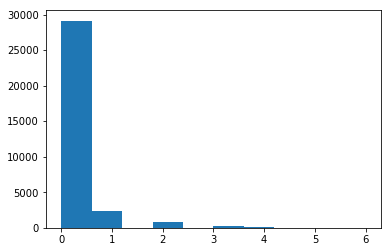

In [8]:
hist(p.flatten(),10);

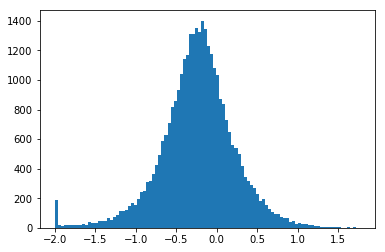

In [9]:
hist(log10(d+0.01).flatten(),100);

In [10]:
lins, fins, finsample = [], [], []
for seed in range(10000):
    lins.append(np.load(path.format(seed)+'s.npy'))
    fins.append(np.load(path.format(seed)+'d.npy'))
    finsample.append(np.load(path.format(seed)+'p.npy'))

lins = np.array(lins)
fins = np.array(fins)
finsample = np.array(finsample)

In [11]:
lins.shape, fins.shape, finsample.shape

((10000, 32, 32, 32), (10000, 32, 32, 32), (10000, 32, 32, 32))

In [12]:
inits = lins.copy()

In [13]:

def evolvefinal( xinit):
    tf.reset_default_graph()

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    icstate = tfpm.lptinit(xrecon, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(xrecon)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sample = sess.run(final)
    return sample

# Module

In [14]:
from utils.bijectors import Squeeze3d, Conv1x1_3D, AffineGlow3d, Actnorm3D 
import tensorflow_probability as tfp
import tensorflow as tf
import itertools
tfd = tfp.distributions
tfb = tfp.bijectors

In [15]:
tf.reset_default_graph()
input_shape = 32
cube_size = 32
nchannels = 1
batch_size = 32

xx = tf.placeholder(tf.float32, shape=[batch_size, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[batch_size, nc, nc, nc], name='ouput')

def mk_glow_steps(name, nsteps, is_training=True):
    chain = [[AffineGlow3d(name='%s/coupling_%d'%(name,i)),
              Conv1x1_3D(name='%s/conv1x1_%d'%(name,i)), #AffineGlow3d(name='%s/coupling_%d'%(name,i)),
              tfb.BatchNormalization(training=is_training, name='%s/bn_%d'%(name,i))] 
             for i in range(nsteps)]
    return list(itertools.chain.from_iterable(chain))

glow = tfb.Chain(
    [tfb.Invert(Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels]))] +
    mk_glow_steps('block1', 4)  +    
    [tfb.Invert(Squeeze3d(event_shape_in=[cube_size//2,cube_size//2,cube_size//2,nchannels*8]))] +
    mk_glow_steps('block2', 4)  +
    [Squeeze3d(event_shape_in=[cube_size//2,cube_size//2,cube_size//2,nchannels*8])] +
    mk_glow_steps('block5', 4)  +
    [Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels])])


prior = tfd.Independent(tfd.Normal(loc=tf.expand_dims(xx, -1), scale=1))
distribution = tfd.TransformedDistribution(distribution=prior,
                                               bijector=glow)
loglik = distribution.log_prob(tf.expand_dims(yy, -1))


loss = -loglik #tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use keras.layers.conv3d instead.
Instructions for updating:
Colocations handled automatically by placer.


/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead',

Instructions for updating:
Use tf.cast instead.


/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [16]:
data_size = 8000

inds = np.random.randint(0, data_size, batch_size)
x = fins[inds]
y = finsample[inds]

l = sess.run(loss, feed_dict={xx:x, yy:y, lr:0.0001})

In [17]:
l

300293.12

In [18]:
z = glow.inverse(tf.expand_dims(yy, -1))

In [20]:
sess.run(loss, feed_dict={xx:x, yy:y, lr:0.0001})

300293.12

In [21]:
losses =[]

In [30]:
data_size = 8000

for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append( l)   
    if i%300 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(100000):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
        
# learn = sess.run(z, feed_dict={xx:fins[inds]})
# learnrate = sess.run(distribution.sample(), feed_dict={xx:fins[inds]})

-21403.27
-37282.848
-49361.227
-61254.293
-78945.11
-80945.34
-86204.74
-86525.04
-93292.164
-94273.84
-96465.76
-103307.47
-104194.484
-103795.22
-88015.17
-106879.69
-109781.75
-114131.516
-118642.38
-121245.03
-116839.02
-126489.86
-122293.75
-126801.45
-120785.11
-126192.66
-130153.08
-129406.33
-130134.484
-132420.78
-131916.17
-132825.69
-131899.47
-131998.19
-132218.69
-147570.64
-139986.25
-150314.06
-145882.6
-150013.34
-146709.31
-149767.22
-152399.84
-153681.86
-152874.84
-150755.52
-149652.16
-150154.1
-150335.19
-151315.2
-150613.53
-151084.5
-152148.25
-150520.0
-151800.36
-152055.47
-151679.56
-152501.75
-152640.83
-154037.66
-154163.78
-152816.53
-154803.69
-157441.69
-144762.34
-152254.75
-157368.81
-155347.5
-156346.7
-156193.62
-156697.44
-153881.34
-150199.48
-156284.12
-145204.25
-156084.94
-151500.12
-156241.39
-155689.25
-161477.9
-152603.03
-156232.4
-154116.22
-158343.4
-160854.28
-153306.16
-149866.67
-153454.75
-159691.17
-158969.19
-146215.1
-150027.56
-143

In [ ]:
for i in range(100000):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.00001})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)

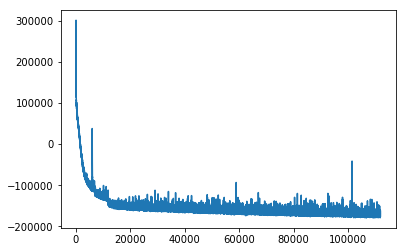

In [31]:
plot(losses)

In [32]:

learn = sess.run(z, feed_dict={xx:fins[0:32], yy:finsample[0:32]})
learnrate = sess.run(distribution.sample(), feed_dict={xx:fins[0:32], yy:finsample[0:32]})

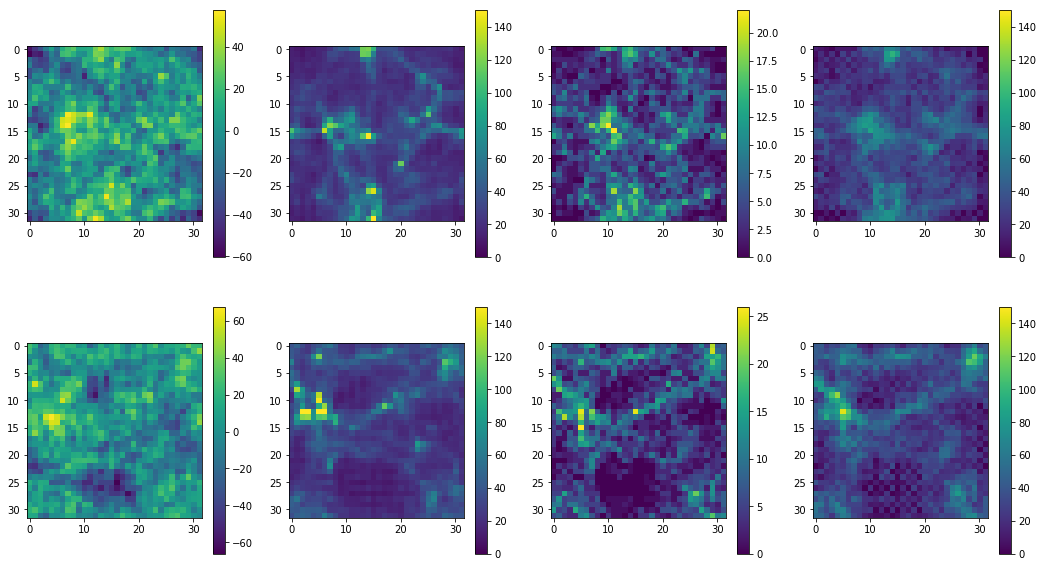

In [38]:

fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 7
axis = ax[0]
im = axis[0].imshow(inits[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii].sum(axis=0), vmin=0, vmax=150)
colorbar(im, ax=axis[1])
im = axis[2].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learn[ii].sum(axis=0)[...,0], vmin=0, vmax=150)
colorbar(im, ax=axis[3])
ii = 10
axis = ax[1]
im = axis[0].imshow(inits[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii].sum(axis=0), vmin=0, vmax=150)
colorbar(im, ax=axis[1])
im = axis[2].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learn[ii].sum(axis=0)[...,0], vmin=0, vmax=150)
colorbar(im, ax=axis[3])

In [39]:
learnrate

array([[[[[            nan],
          [            nan],
          [            nan],
          ...,
          [            nan],
          [            nan],
          [            nan]],

         [[            nan],
          [            nan],
          [            nan],
          ...,
          [            nan],
          [            nan],
          [            nan]],

         [[            nan],
          [            nan],
          [            nan],
          ...,
          [            nan],
          [            nan],
          [            nan]],

         ...,

         [[            nan],
          [            nan],
          [            nan],
          ...,
          [            nan],
          [            nan],
          [            nan]],

         [[            nan],
          [            nan],
          [            nan],
          ...,
          [            nan],
          [            nan],
          [            nan]],

         [[            nan],
 

In [12]:
# modname = './modules/densemoduleza3dsample'
# module = hub.Module(modname, trainable=False)
# sample = module({'features':lins, 'labels':finsample}, as_dict=True)['sample']
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     learn = sess.run(sample)


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


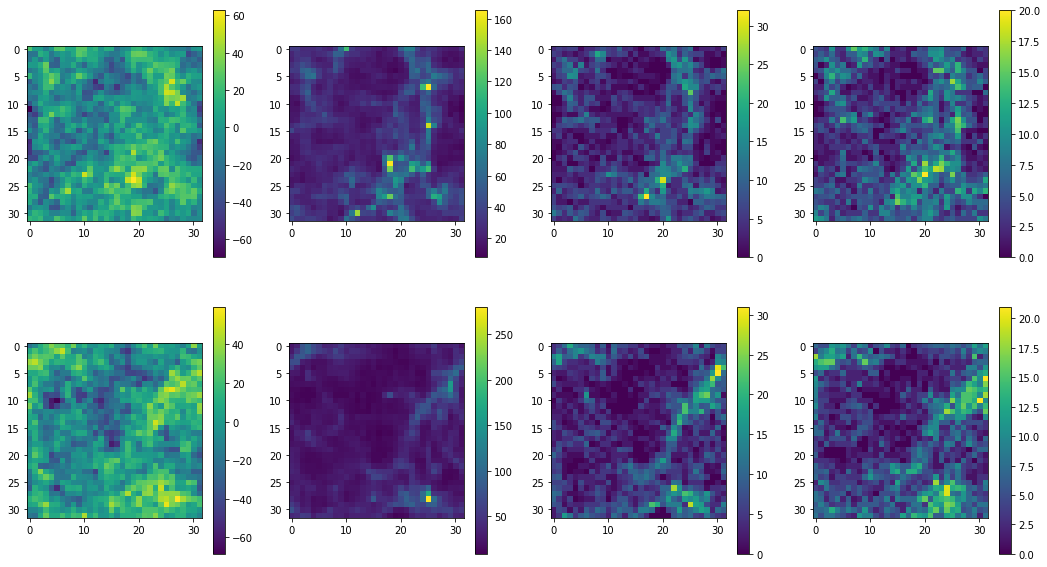

In [13]:
# plot(losses[1:])
# plt.yscale('log')
# plt.xscale('log')
# plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 90
axis = ax[0]
im = axis[0].imshow(inits[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[3])
ii = 900
axis = ax[1]
im = axis[0].imshow(inits[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[3])


In [91]:
%%bash
ls modules/
# rm -r ./modules/densemoduleza3dsample


densemodule
densemoduleza
densemoduleza2d
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [41]:
module.export('./modules/densemoduleza3dsample', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemoduleza3dsample


# Reconstruct here

In [288]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def dorecon(yy, xinit, modname, useprior=True, niter=5000, lr=0.001, sampleonly=False):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    sample = module({'features':xrecon, 'labels':yy}, as_dict=True)['sample']
    if sampleonly: 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sample = sess.run(sample)
        return sample
    loglik = module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']
    loglik = -tf.reduce_sum(loglik, axis=(1, 2, 3))
    
    xreconk = tfpmfuncs.r2c3d(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=(1, 2, 3))
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(loglik, prior)

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%300==0: print(l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [41]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsample///'
xrecons = []
losses = []
priors = []
xinit = []

nstart = 10

ir = [900]
for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn(nstart, nc, nc, nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=5000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xrecons.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(10,), dtype=float32) Tensor("prior:0", shape=(10,), dtype=float32)
17817.627
10906.826
10448.668
10225.157
10078.248
9975.321
9879.584
9792.367
9746.901
9685.096
9651.662
9607.949
9573.071
9520.205
9484.521
9460.191
9427.868


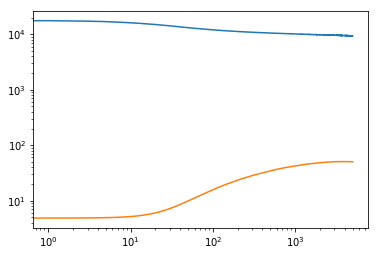

In [42]:
ii = 0
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
plt.yscale('log')
plt.xscale('log')


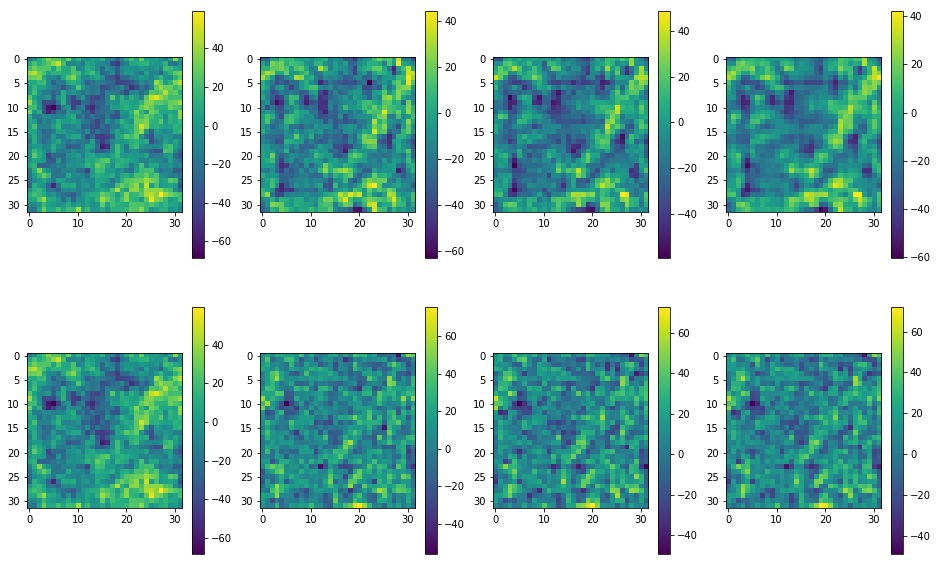

In [43]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow(xrecons[0][0].sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow(xrecons[0][5].sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow(xrecons[0].mean(axis=0).sum(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow((inits[ir[0]]-xrecons[0][0]).sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow((inits[ir[0]]-xrecons[0][5]).sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow((inits[ir[0]]-xrecons[0].mean(axis=0)).sum(axis=0))
colorbar(im, ax=ax[3])


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


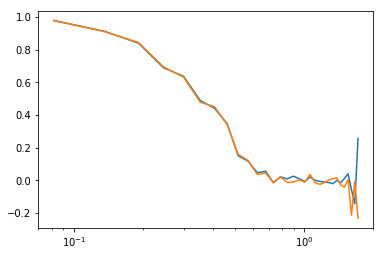

In [ ]:
kk, p1 = tools.power(inits[ir[0]], boxsize=bs)
kk, p2 = tools.power(xrecons[0][0], boxsize=bs)
kk, p12 = tools.power(inits[ir[0]], xrecons[0][0], boxsize=bs)
kk, p2all = tools.power(xrecons[0].mean(axis=0), boxsize=bs)
kk, p12all = tools.power(inits[ir[0]], xrecons[0].mean(axis=0), boxsize=bs)

plt.plot(kk, p12/(p1*p2)**0.5)
plt.plot(kk, p12all/(p1*p2all)**0.5)
plt.xscale('log')

In [296]:
modname = './modules/densemoduleza3dsample///'
samplexrecons = dorecon(xrecons[0]*0, xrecons[0], modname=modname, sampleonly=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Train model on final field

In [18]:

tf.reset_default_graph()


nfilter = 16
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.00)

    xx = tf.expand_dims(x, -1)
    net = tf.layers.conv3d(xx,nfilter, 5, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    
    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv3d(net,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = net + tf.layers.conv3d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same')
    net = tf.nn.dropout(net, 0.95)

    net = tf.layers.conv3d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
    net = tf.layers.conv3d(net,1, 1, kernel_regularizer=reg,padding='same')

    lognet = tf.layers.conv3d(net, 1, 1, kernel_regularizer=reg,padding='same', 
                              name='lograte')    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik #tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 800
batch_size = 32

for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.002})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append( l)   
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
    if np.isnan(l): 
        print(i, l)
        break
    losses.append(l)
    if i%300 ==0: print(l)
        
print('Done', l)
if ~np.isnan(l):
    learnfin = sess.run(sample, feed_dict={xx:fins, yy:y})
    learnfinrate = sess.run(rate, feed_dict={xx:fins, yy:y})

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.926661
0.30258912
0.28362682
0.2724406
0.2667967
0.26335642
Done 0.2620289


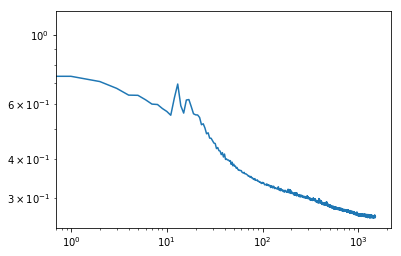

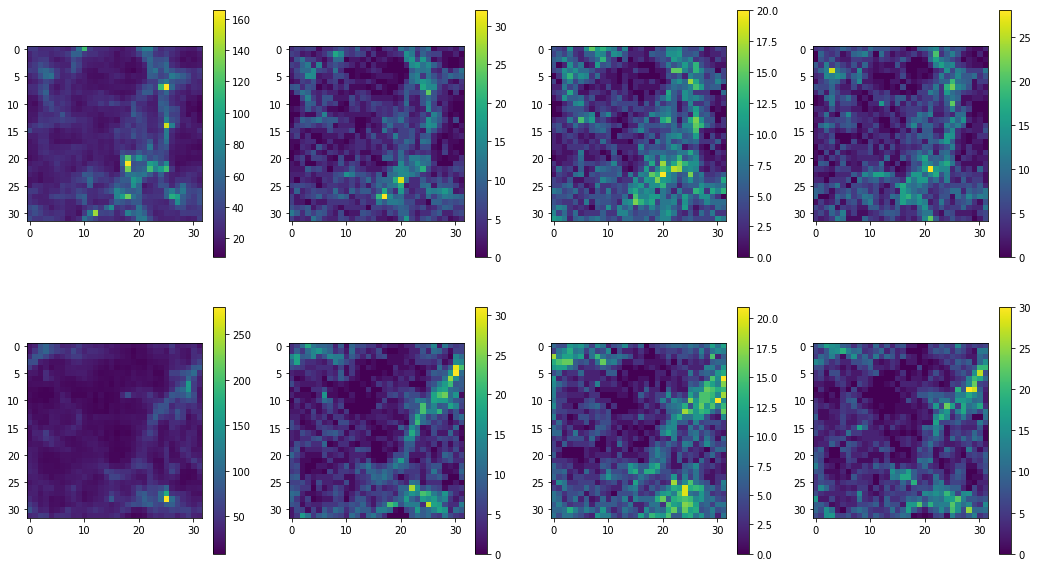

In [19]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 90
axis = ax[0]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnfin[ii].sum(axis=0))
colorbar(im, ax=axis[3])
ii = 900
axis = ax[1]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnfin[ii].sum(axis=0))
colorbar(im, ax=axis[3])


In [22]:
%%bash
ls modules/
rm -r ./modules/densemoduleza3dsamplefin


densemodule
densemoduleza
densemoduleza2d
densemoduleza2dsample
densemoduleza3dsample
densemoduleza3dsamplefin
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemoduleza2d
specdensemoduleza2dsample
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [23]:
module.export('./modules/densemoduleza3dsamplefin', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemoduleza3dsamplefin


### Reconstruct with fin model

In [284]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def doreconfin(yy, xinit, modname, useprior=True, niter=5000, lr=0.001, sampleonly=False):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    icstate = tfpm.lptinit(xrecon, config, name='icstate')
    fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
    final = tf.zeros_like(xrecon)
    final = tfpf.cic_paint(final, fnstate[0], boxsize=config['boxsize'], name='final')

    sample = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['sample']
    if sampleonly: 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sample = sess.run(sample)
        return sample
    
        
    loglik = module({'features':tf.expand_dims(final, 0), 'labels':yy}, as_dict=True)['loglikelihood']
    loglik = -tf.reduce_sum(loglik, axis=(1, 2, 3))
    
    xreconk = tfpmfuncs.r2c3d(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=(0, 1, 2))
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(loglik, prior)

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%300==0: print(l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [49]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsamplefin/'
# xreconsfin = []
losses = []
priors = []
xinit = []

nstart = 1

ir = [900]
for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
#     xi = 1*randn( nc, nc, nc)
#     xi = xi.astype('float32')
    xi = xreconsfin[0].copy()

    recons = doreconfin(yy, xi, modname, useprior=True, niter=5000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xreconsfin.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(1,), dtype=float32) Tensor("prior:0", shape=(), dtype=float32)
27944.781
7516.217
7147.25
6954.117
6853.961
6784.767
6712.6255
6664.348
6639.1436
6608.581
6567.3125
6589.1245
6553.035
6544.784
6530.442
6540.6587
6524.9707


In [59]:
for ii in ir:
#     ii = 2*i
    xi = xreconsfin[0].copy()
    recons = doreconfin(yy, xi, modname, useprior=True, niter=5000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xreconsfin.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(1,), dtype=float32) Tensor("prior:0", shape=(), dtype=float32)
6523.891
6523.4775
6503.5195
6514.954
6529.956
6508.2734
6496.627
6534.263
6487.9604
6513.748
6498.809
6505.2593
6512.897
6501.642
6507.6455
6491.307
6506.487


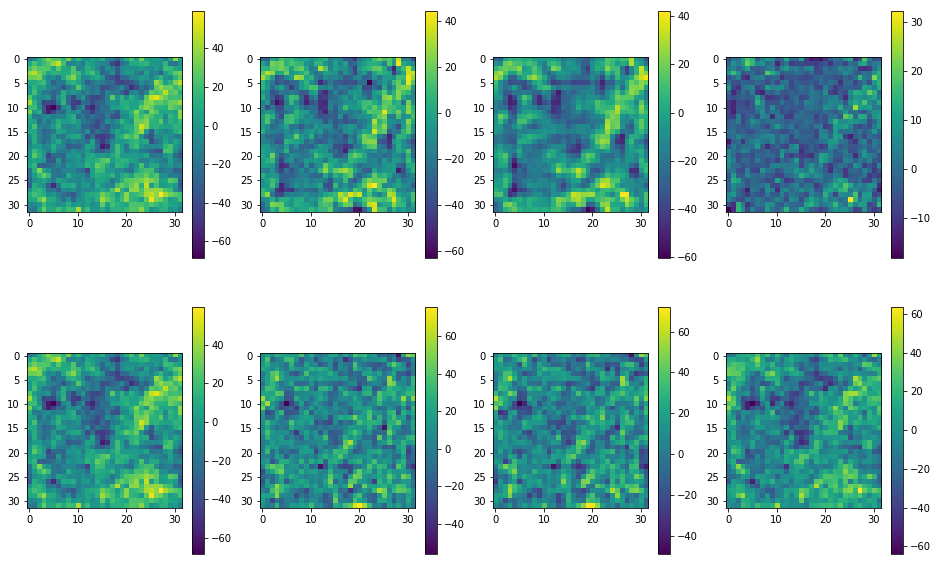

In [62]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow(xrecons[0][0].sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow(xrecons[0].mean(axis=0).sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow(xreconsfin[-1].sum(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow((inits[ir[0]]-xrecons[0][0]).sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow((inits[ir[0]]-xrecons[0].mean(axis=0)).sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow((inits[ir[0]]-xreconsfin[-1]).sum(axis=0))
colorbar(im, ax=ax[3])


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


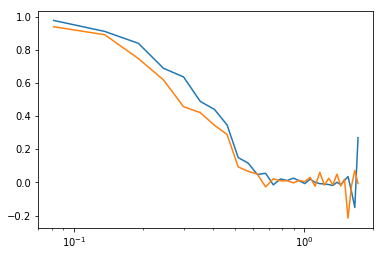

In [63]:
kk, p1 = tools.power(inits[ir[0]], boxsize=bs)
kk, p2 = tools.power(xrecons[0][0], boxsize=bs)
kk, p12 = tools.power(inits[ir[0]], xrecons[0][0], boxsize=bs)
kk, p2all = tools.power(xreconsfin[-1], boxsize=bs)
kk, p12all = tools.power(inits[ir[0]], xreconsfin[-1], boxsize=bs)

plt.plot(kk, p12/(p1*p2)**0.5)
plt.plot(kk, p12all/(p1*p2all)**0.5)
plt.xscale('log')

In [302]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsamplefin/'
samplexreconsfin = doreconfin(np.expand_dims(xreconsfin[-1], axis=0)*0, xreconsfin[-1], modname=modname,  sampleonly=True)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


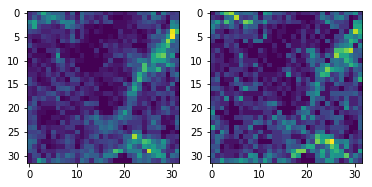

In [303]:
ax = plt.subplot(1, 2, 1)
plt.imshow(finsample[ir[0]].sum(axis=0))
ax = plt.subplot(1, 2, 2)
plt.imshow(samplexreconsfin.sum(axis=0))

# Custom dense layer

In [120]:
tf.glorot_normal_initializer()

In [230]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv3d as specconv3d


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 16
num_iters = 1
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    xx = tf.expand_dims(x, -1)

    net = specconv3d(xx, nfilter, 5, num_iters=num_iters)
    net = activation=tf.nn.leaky_relu(net)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l11', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l12', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l21', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l22', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l31', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l32', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l41', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l42', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = specconv3d(net,1, 3, name='l51', num_iters=num_iters)
    net = tf.nn.leaky_relu(net)
    net = specconv3d(net,1, 1, name='l61', num_iters=num_iters)

    lognet = specconv3d(net, 1, 1, name='l61', num_iters=num_iters)
    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':net})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = -tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 800
batch_size = 32

for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

        
        
learnspec = sess.run(sample, feed_dict={xx:inits, yy:y})
learnspecrate = sess.run(rate, feed_dict={xx:inits, yy:y})


../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.66088754
0.3933733
0.3798633
0.37381434
0.37135574
0.36796284


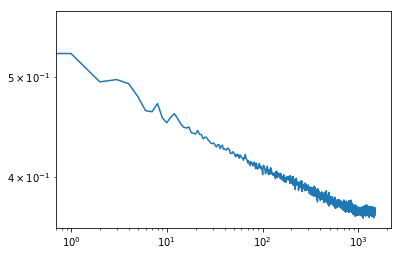

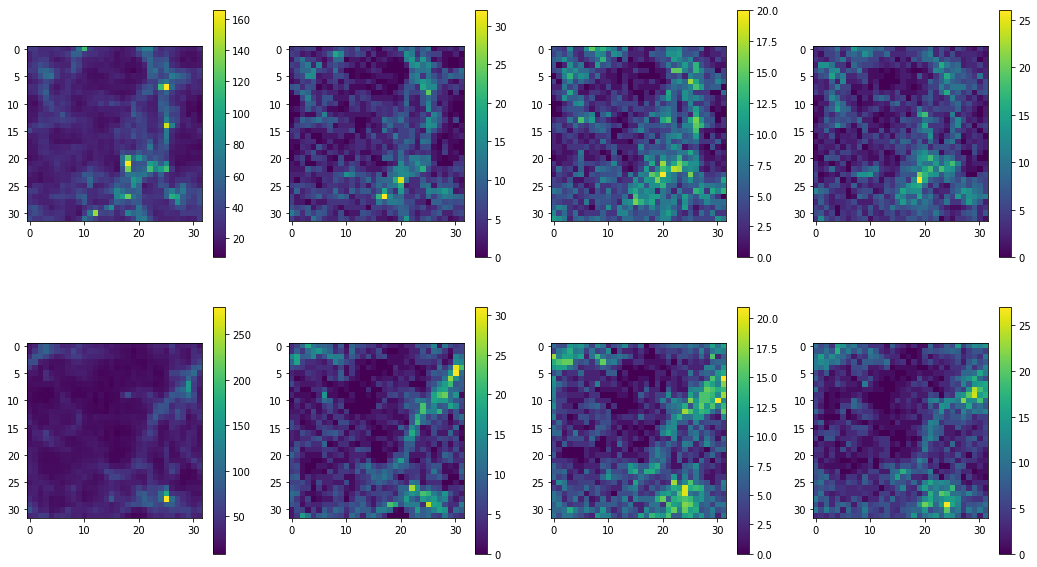

In [231]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 90
axis = ax[0]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])

im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnspec[ii].sum(axis=0))
colorbar(im, ax=axis[3])
ii = 900
axis = ax[1]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learn[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnspec[ii].sum(axis=0))
colorbar(im, ax=axis[3])


In [87]:
%%bash
ls ./modules/
rm -r ./modules/specdensemoduleza3dsample


densemodule
densemoduleza
densemoduleza2d
densemoduleza2dsample
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemoduleza2d
specdensemoduleza2dsample
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [232]:
module.export('./modules/specdensemoduleza3dsample', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemoduleza3dsample


## recon again 

In [234]:
tf.reset_default_graph()
modname = './modules/densemoduleza3dsample//'
xreconsspec = []
losses = []
priors = []
xinitspec = []

nstart = 50
ir = [900]

for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn(nstart, nc, nc, nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=3000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xreconsspec.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinitspec.append(xi)




INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(50,), dtype=float32) Tensor("prior:0", shape=(50,), dtype=float32)
17813.207
10893.569
10400.523
10172.109
10040.177
9913.443
9815.564
9748.837
9683.555
9622.544
9566.624


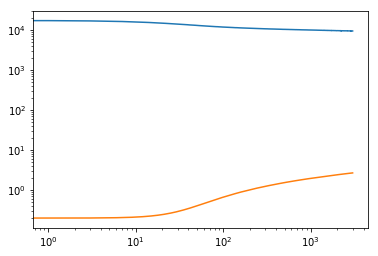

In [235]:
ii = 5
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
plt.yscale('log')
plt.xscale('log')
plt.show()


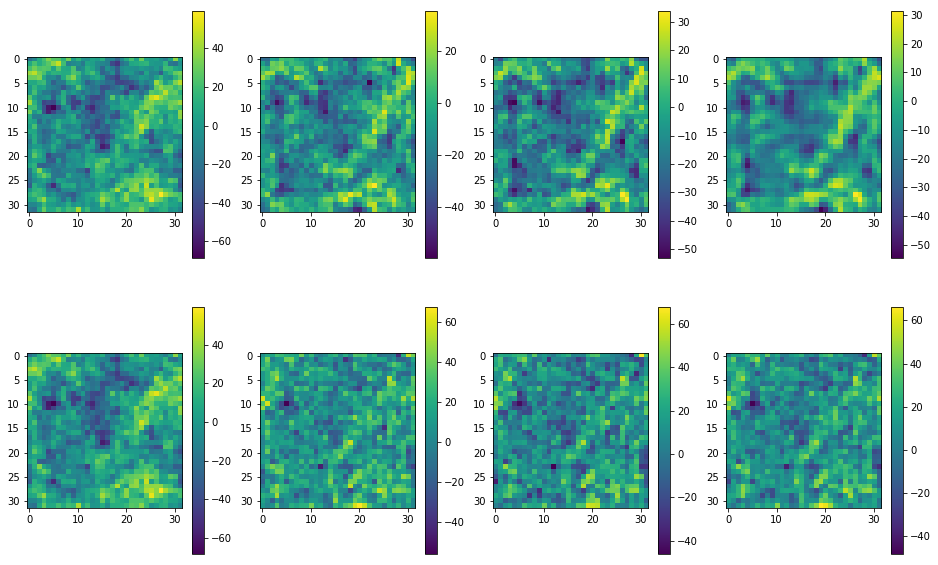

In [239]:
fig, axar = plt.subplots(2,4,figsize=(16, 10))

ax = axar[0]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow(xreconsspec[0][0].sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow(xreconsspec[0][25].sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow(xreconsspec[0].mean(axis=0).sum(axis=0))
colorbar(im, ax=ax[3])

ax = axar[1]
im = ax[0].imshow(inits[ir[0]].sum(axis=0))
colorbar(im, ax=ax[0])
im = ax[1].imshow((inits[ir[0]]-xreconsspec[0][0]).sum(axis=0))
colorbar(im, ax=ax[1])
im = ax[2].imshow((inits[ir[0]]-xreconsspec[0][25]).sum(axis=0))
colorbar(im, ax=ax[2])
im = ax[3].imshow((inits[ir[0]]-xreconsspec[0].mean(axis=0)).sum(axis=0))
colorbar(im, ax=ax[3])


In [305]:
modname = './modules/specdensemoduleza3dsample//'
samplexreconsspec = dorecon(xreconsspec[0]*0, xreconsspec[0], modname=modname, sampleonly=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Custom dense from final

In [347]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv3d as specconv3d


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 16
num_iters = 1
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='output')

    xx = tf.expand_dims(x, -1)

    net = specconv3d(xx, nfilter, 5, num_iters=num_iters)
    net = activation=tf.nn.leaky_relu(net)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l11', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l12', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l21', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l22', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l31', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l32', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv3d(net, nfilter, 3, name='l41', num_iters=num_iters)
    net = net + specconv3d(subnet,nfilter, 3, name='l42', num_iters=num_iters)
    net = tf.nn.dropout(net, 0.95)

    net = specconv3d(net,1, 3, name='l51', num_iters=num_iters)
    net = tf.nn.leaky_relu(net)
    net = specconv3d(net,1, 1, name='l61', num_iters=num_iters)

    lognet = specconv3d(net, 1, 1, name='l61', num_iters=num_iters)
    
    net = tf.nn.softplus(lognet)
    net= tf.squeeze(net)
    net = tf.identity(net, name='rate')
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    loglik = mixture_dist.log_prob(y)
    
    
    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':lognet, 'rate':net})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc, nc, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = -tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 800
batch_size = 32

for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)
for i in range(500):
    inds = np.random.randint(0, data_size, batch_size)
    x = fins[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    if np.isnan(l): print(i, l)
    losses.append(l)
    if i%300 ==0: print(l)

        
        
learnspecfin = sess.run(sample, feed_dict={xx:fins, yy:y})
learnspecfinrate = sess.run(rate, feed_dict={xx:fins, yy:y})


../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
1.8885372
0.32450172
0.31255922
0.29957074
0.29223034
0.2931342


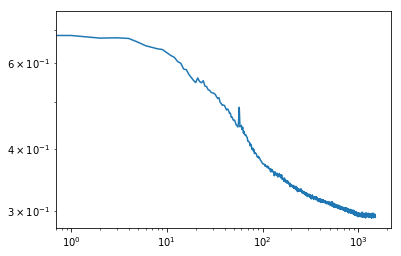

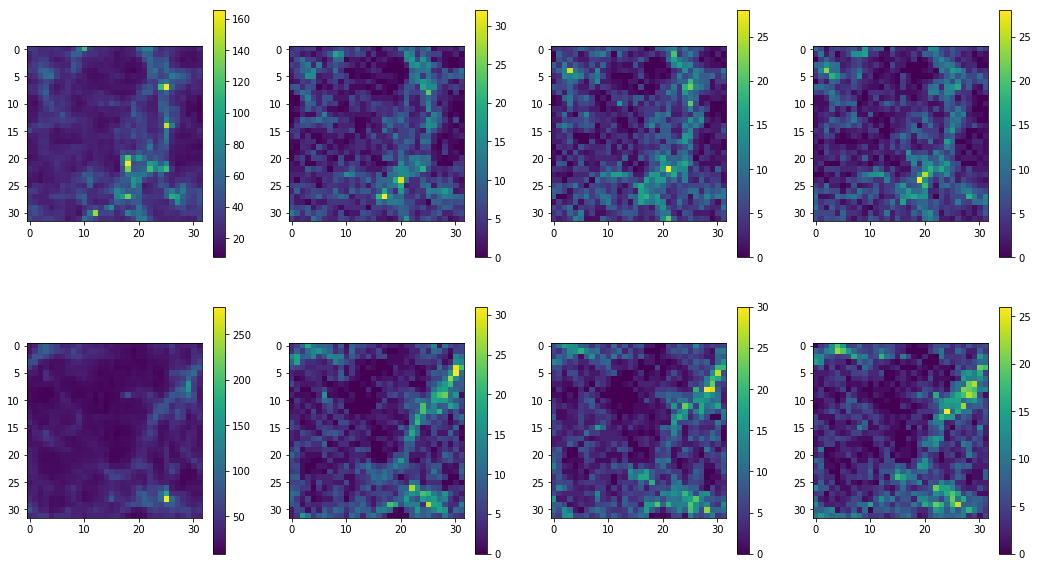

In [349]:
plot(losses[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()


fig, ax = plt.subplots(2, 4, figsize = (18, 10))
ii = 90
axis = ax[0]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learnfin[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnspecfin[ii].sum(axis=0))
colorbar(im, ax=axis[3])
ii = 900
axis = ax[1]
im = axis[0].imshow(fins[ii].sum(axis=0))
colorbar(im, ax=axis[0])
im = axis[1].imshow(finsample[ii].sum(axis=0))
colorbar(im, ax=axis[1])
im = axis[2].imshow(learnfin[ii].sum(axis=0))
colorbar(im, ax=axis[2])
im = axis[3].imshow(learnspecfin[ii].sum(axis=0))
colorbar(im, ax=axis[3])


In [351]:
%%bash
ls ./modules/
rm -r ./modules/specdensemoduleza3dsamplefin


densemodule
densemoduleza
densemoduleza2d
densemoduleza2dsample
densemoduleza3dsample
densemoduleza3dsamplefin
densemodulezanormal
densemodulezapoisson
fwdmodel
fwdmodelza2d
specdensemodule
specdensemoduleza
specdensemoduleza2d
specdensemoduleza2dsample
specdensemoduleza3dsample
specdensemoduleza3dsamplefin
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [352]:
module.export('./modules/specdensemoduleza3dsamplefin', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemoduleza3dsamplefin


## recon again

In [353]:
tf.reset_default_graph()
modname = './modules/specdensemoduleza3dsamplefin/'
xreconsspecfin = []
losses = []
priors = []
xinit = []

nstart = 1

ir = [900]
for ii in ir:
#     ii = 2*i
    np.random.seed(100)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn( nc, nc, nc)
    xi = xi.astype('float32')

    recons = doreconfin(yy, xi, modname, useprior=True, niter=5000, lr=0.01)
    xrecon = np.squeeze(recons[0])
    xreconsspecfin.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(1,), dtype=float32) Tensor("prior:0", shape=(), dtype=float32)
22149.938
9348.252
8893.08
8662.28
8535.064
8430.023
8347.461
8305.127
8216.727
8192.403
8178.2812
8150.3794
8119.0015
8101.059
8096.356
8085.8228
8073.9097


In [366]:
modname = './modules/specdensemoduleza3dsamplefin/'
samplexreconsspecfin = doreconfin(np.expand_dims(xreconsspecfin[0], 0)*0, 
                               xreconsspecfin[0], modname=modname, sampleonly=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Compare recon

In [358]:

finalxrecons = evolvefinal(xrecons[0][0])
finalxreconsfin = evolvefinal(xreconsfin[0])
finalxreconsspec = evolvefinal(xreconsspec[0][0])
finalxreconsspecfin = evolvefinal(xreconsspecfin[0])

In [243]:
truth = lins[ir[0]]
data = finsample[ir[0]]

[]

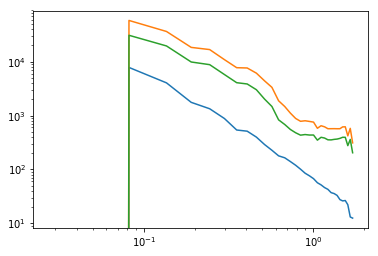

In [244]:
kk, pp = tools.power(truth+1, boxsize=bs)
plt.plot(kk, pp)
kk, pp = tools.power(xrecons[0][0], boxsize=bs)
plt.plot(kk, pp)
kk, pp = tools.power(xreconsspec[0][0], boxsize=bs)
plt.plot(kk, pp)
plt.loglog()

Text(0.5, 1.0, 'Recon from final network')

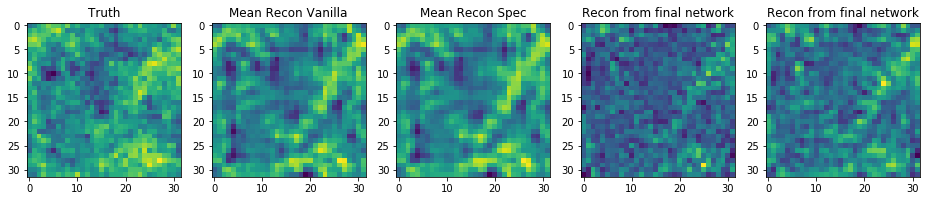

In [359]:
fig, ax = plt.subplots(1, 5, figsize = (16, 4))
ax[0].imshow(truth.sum(axis=0))
ax[0].set_title('Truth')
ax[1].imshow(xrecons[0].mean(axis=0).sum(axis=0))
ax[1].set_title('Mean Recon Vanilla')
ax[2].imshow(xreconsspec[0].mean(axis=0).sum(axis=0))
ax[2].set_title('Mean Recon Spec')
ax[3].imshow(xreconsfin[0].sum(axis=0))
ax[3].set_title('Recon from final network')
ax[4].imshow(xreconsspecfin[0].sum(axis=0))
ax[4].set_title('Recon from final network')


Text(0.5, 1.0, 'Recon from final Spec net')

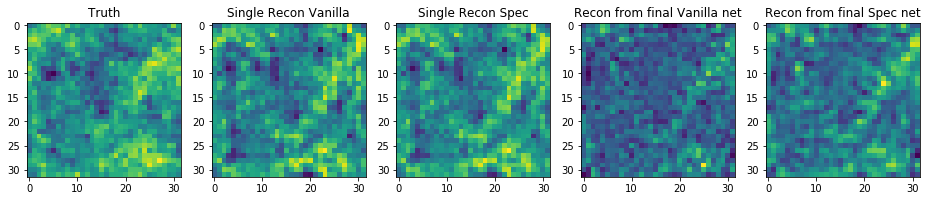

In [360]:
fig, ax = plt.subplots(1, 5, figsize = (16, 4))
ax[0].imshow(truth.sum(axis=0))
ax[0].set_title('Truth')
ax[1].imshow(xrecons[0][0].sum(axis=0))
ax[1].set_title('Single Recon Vanilla')
ax[2].imshow(xreconsspec[0][0].sum(axis=0))
ax[2].set_title('Single Recon Spec')
ax[3].imshow(xreconsfin[0].sum(axis=0))
ax[3].set_title('Recon from final Vanilla net')
ax[4].imshow(xreconsspecfin[0].sum(axis=0))
ax[4].set_title('Recon from final Spec net')


Text(0.5, 1.0, 'Recon from final network')

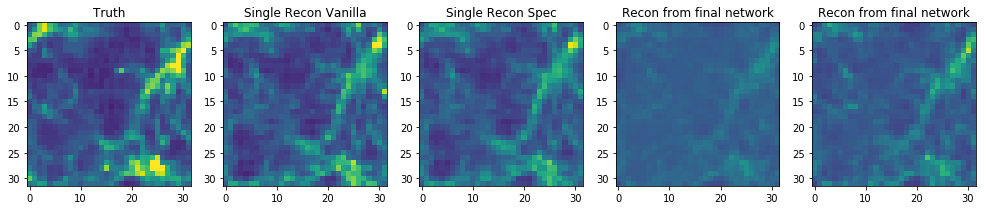

In [361]:
vmax = 100

fig, ax = plt.subplots(1, 5, figsize = (17, 8))
im = ax[0].imshow(fins[ir[0]].sum(axis=0), vmin=0, vmax=vmax)
ax[0].set_title('Truth')
# plt.colorbar(im)
ax[1].imshow(finalxrecons.sum(axis=0), vmin=0, vmax=vmax)
ax[1].set_title('Single Recon Vanilla')
ax[2].imshow(finalxreconsspec.sum(axis=0), vmin=0, vmax=vmax)
ax[2].set_title('Single Recon Spec')
ax[3].imshow(finalxreconsfin.sum(axis=0), vmin=0, vmax=vmax)
ax[3].set_title('Recon from final network')
ax[4].imshow(finalxreconsspecfin.sum(axis=0), vmin=0, vmax=vmax)
ax[4].set_title('Recon from final network')


Text(0.5, 1.0, 'Recon from final network')

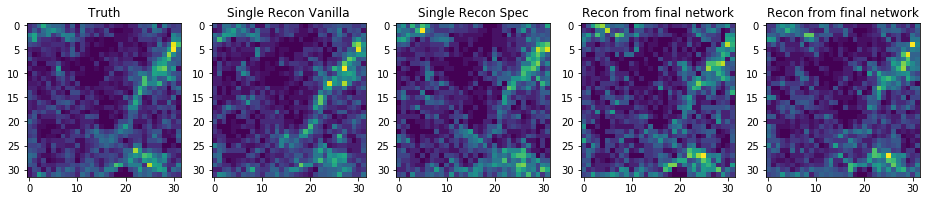

In [368]:
fig, ax = plt.subplots(1, 5, figsize = (16, 8))
ax[0].imshow(data.sum(axis=0))
ax[0].set_title('Truth')
ax[1].imshow(samplexrecons[0].sum(axis=0))
ax[1].set_title('Single Recon Vanilla')
ax[2].imshow(samplexreconsspec[0].sum(axis=0))
ax[2].set_title('Single Recon Spec')
ax[3].imshow(samplexreconsfin.sum(axis=0))
ax[3].set_title('Recon from final network')
ax[4].imshow(samplexreconsspecfin.sum(axis=0))
ax[4].set_title('Recon from final network')


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Text(0.5, 0.98, 'Compare mean recon vs single recon')

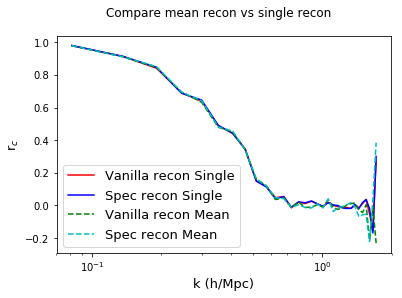

In [334]:
kk, p1 = tools.power(truth+1, boxsize=bs)
kk, p2 = tools.power(xrecons[0][0]+1, boxsize=bs)
kk, p3 = tools.power(xreconsspec[0][0]+1, boxsize=bs)
kk, p12 = tools.power(truth+1, xrecons[0][0]+1, boxsize=bs)
kk, p13 = tools.power(truth+1, xreconsspec[0][0]+1, boxsize=bs)

kk, p2all = tools.power(xrecons[0].mean(axis=0)+1, boxsize=bs)
kk, p3all = tools.power(xreconsspec[0].mean(axis=0)+1, boxsize=bs)
kk, p12all = tools.power(truth+1, xrecons[0].mean(axis=0)+1, boxsize=bs)
kk, p13all = tools.power(truth+1, xreconsspec[0].mean(axis=0)+1, boxsize=bs)

plt.plot(kk, p12/(p1*p2)**.5, 'r', label='Vanilla recon Single')
plt.plot(kk, p13/(p1*p3)**.5, 'b', label='Spec recon Single')

plt.plot(kk, p12all/(p1*p2all)**.5, 'g--', label='Vanilla recon Mean')
plt.plot(kk, p13all/(p1*p3all)**.5, 'c--', label='Spec recon Mean')

ii = 1
kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(learn[ii], boxsize=bs)
kk, p3 = tools.power(learnspec[ii], boxsize=bs)
kk, p4 = tools.power(learnfin[ii], boxsize=bs)
kk, p12 = tools.power(finsample[ii], learn[ii], boxsize=bs)
kk, p13 = tools.power(finsample[ii], learnspec[ii], boxsize=bs)
kk, p14 = tools.power(finsample[ii], learnfin[ii], boxsize=bs)

# plt.plot(kk, p12/(p1*p2)**.5, 'k', label='Learn Vanilla')
# plt.plot(kk, p13/(p1*p3)**.5, 'k--', label='Learn Spec')
# plt.plot(kk, p14/(p1*p4)**.5, 'k:', label='Learn Vanilla Fin')


plt.xscale('log')
plt.xlabel('k (h/Mpc)', fontsize=13)
plt.ylabel('r$_c$', fontsize=13)
plt.legend(fontsize=13)

plt.suptitle('Compare mean recon vs single recon')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Correlation compare for train and recon linear')

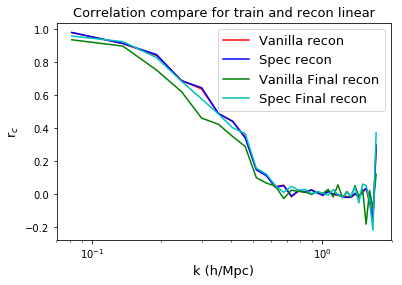

In [372]:
kk, p1 = tools.power(truth+1, boxsize=bs)
kk, p2 = tools.power(xrecons[0][0]+1, boxsize=bs)
kk, p3 = tools.power(xreconsspec[0][0]+1, boxsize=bs)
kk, p4 = tools.power(xreconsfin[0]+1, boxsize=bs)
kk, p5 = tools.power(xreconsspecfin[0]+1, boxsize=bs)

kk, p12 = tools.power(truth+1, xrecons[0][0]+1, boxsize=bs)
kk, p13 = tools.power(truth+1, xreconsspec[0][0]+1, boxsize=bs)
kk, p14 = tools.power(truth+1, xreconsfin[0]+1, boxsize=bs)
kk, p15 = tools.power(truth+1, xreconsspecfin[0]+1, boxsize=bs)

plt.plot(kk, p12/(p1*p2)**.5, 'r', label='Vanilla recon')
plt.plot(kk, p13/(p1*p3)**.5, 'b', label='Spec recon')
plt.plot(kk, p14/(p1*p4)**.5, 'g', label='Vanilla Final recon')
plt.plot(kk, p15/(p1*p5)**.5, 'c', label='Spec Final recon')


ii = 1
kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(learn[ii], boxsize=bs)
kk, p3 = tools.power(learnspec[ii], boxsize=bs)
kk, p4 = tools.power(learnfin[ii], boxsize=bs)
kk, p12 = tools.power(finsample[ii], learn[ii], boxsize=bs)
kk, p13 = tools.power(finsample[ii], learnspec[ii], boxsize=bs)
kk, p14 = tools.power(finsample[ii], learnfin[ii], boxsize=bs)

# plt.plot(kk, p12/(p1*p2)**.5, 'r--', label='Learn Vanilla')
# plt.plot(kk, p13/(p1*p3)**.5, 'b--', label='Learn Spec')
# plt.plot(kk, p14/(p1*p4)**.5, 'g--', label='Learn Vanilla Fin')


plt.xscale('log')
plt.xlabel('k (h/Mpc)', fontsize=13)
plt.ylabel('r$_c$', fontsize=13)
plt.legend(fontsize=13)
plt.title('Correlation compare for train and recon linear', fontsize=13)


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divi

Text(0.5, 1.0, 'Correlation at data level for train & recon')

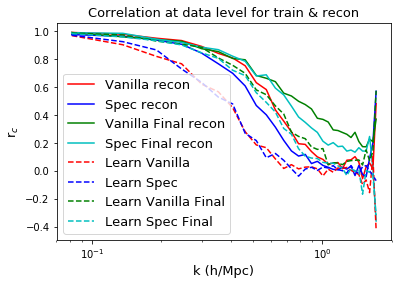

In [375]:
ii = ir[0]
kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(samplexrecons[0], boxsize=bs)
kk, p3 = tools.power(samplexreconsspec[0], boxsize=bs)
kk, p4 = tools.power(samplexreconsfin, boxsize=bs)
kk, p5 = tools.power(samplexreconsspecfin, boxsize=bs)
kk, p12 = tools.power(finsample[ii], samplexrecons[0], boxsize=bs)
kk, p13 = tools.power(finsample[ii], samplexreconsspec[0], boxsize=bs)
kk, p14 = tools.power(finsample[ii], samplexreconsfin, boxsize=bs)
kk, p15 = tools.power(finsample[ii], samplexreconsspecfin, boxsize=bs)

plt.plot(kk, p12/(p1*p2)**.5, 'r', label='Vanilla recon')
plt.plot(kk, p13/(p1*p3)**.5, 'b', label='Spec recon')
plt.plot(kk, p14/(p1*p4)**.5, 'g', label='Vanilla Final recon')
plt.plot(kk, p15/(p1*p5)**.5, 'c', label='Spec Final recon')

kk, p1 = tools.power(finsample[ii], boxsize=bs)
kk, p2 = tools.power(learn[ii], boxsize=bs)
kk, p3 = tools.power(learnspec[ii], boxsize=bs)
kk, p4 = tools.power(learnfin[ii], boxsize=bs)
kk, p5 = tools.power(learnspecfin[ii], boxsize=bs)
kk, p12 = tools.power(finsample[ii], learn[ii], boxsize=bs)
kk, p13 = tools.power(finsample[ii], learnspec[ii], boxsize=bs)
kk, p14 = tools.power(finsample[ii], learnfin[ii], boxsize=bs)
kk, p15 = tools.power(finsample[ii], learnspecfin[ii], boxsize=bs)

plt.plot(kk, p12/(p1*p2)**.5, 'r--', label='Learn Vanilla')
plt.plot(kk, p13/(p1*p3)**.5, 'b--', label='Learn Spec')
plt.plot(kk, p14/(p1*p4)**.5, 'g--', label='Learn Vanilla Final')
plt.plot(kk, p15/(p1*p5)**.5, 'c--', label='Learn Spec Final')


plt.xscale('log')
plt.xlabel('k (h/Mpc)', fontsize=13)
plt.ylabel('r$_c$', fontsize=13)
plt.legend(fontsize=13)
plt.title('Correlation at data level for train & recon', fontsize=13)